In [1]:
import gc
import os
import logging
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold
warnings.filterwarnings('ignore')

In [2]:
IS_LOCAL = False
if(IS_LOCAL):
    PATH="./input/Santander/"
else:
    PATH="./input/"
os.listdir(PATH)

['sample_submission.csv',
 'sample_submission.csv.zip',
 'test.csv',
 'test.csv.zip',
 'train.csv',
 'train.csv.zip']

In [3]:
# %%time
train_df = pd.read_csv(PATH+"train.csv")
test_df = pd.read_csv(PATH+"test.csv")

In [4]:
print(train_df.shape)
print(test_df.shape)

(200000, 202)
(200000, 201)


In [5]:
def missing_data(data):
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    types = []
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
    tt['Types'] = types
    return(np.transpose(tt))

In [6]:
%%time
missing_data(train_df)
# missing_data(test_df)

Wall time: 1.42 s


,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
Total,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Percent,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Types,object,int64,float64,float64,float64,float64,float64,float64,float64,float64,...,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64


In [7]:
%%time
train_df.describe()
# test_df.describe()

Wall time: 2.86 s


,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.100490,10.679914,-1.627622,10.715192,6.796529,11.078333,-5.065317,5.408949,16.545850,0.284162,...,3.234440,7.438408,1.927839,3.331774,17.993784,-0.142088,2.303335,8.908158,15.870720,-3.326537
std,0.300653,3.040051,4.050044,2.640894,2.043319,1.623150,7.863267,0.866607,3.418076,3.332634,...,4.559922,3.023272,1.478423,3.992030,3.135162,1.429372,5.454369,0.921625,3.010945,10.438015
min,0.000000,0.408400,-15.043400,2.117100,-0.040200,5.074800,-32.562600,2.347300,5.349700,-10.505500,...,-14.093300,-2.691700,-3.814500,-11.783400,8.694400,-5.261000,-14.209600,5.960600,6.299300,-38.852800
25%,0.000000,8.453850,-4.740025,8.722475,5.254075,9.883175,-11.200350,4.767700,13.943800,-2.317800,...,-0.058825,5.157400,0.889775,0.584600,15.629800,-1.170700,-1.946925,8.252800,13.829700,-11.208475
50%,0.000000,10.524750,-1.608050,10.580000,6.825000,11.108250,-4.833150,5.385100,16.456800,0.393700,...,3.203600,7.347750,1.901300,3.396350,17.957950,-0.172700,2.408900,8.888200,15.934050,-2.819550
75%,0.000000,12.758200,1.358625,12.516700,8.324100,12.261125,0.924800,6.003000,19.102900,2.937900,...,6.406200,9.512525,2.949500,6.205800,20.396525,0.829600,6.556725,9.593300,18.064725,4.836800
max,1.000000,20.315000,10.376800,19.353000,13.188300,16.671400,17.251600,8.447700,27.691800,10.151300,...,18.440900,16.716500,8.402400,18.281800,27.928800,4.272900,18.321500,12.000400,26.079100,28.500700


In [8]:
def plot_feature_scatter(df1, df2, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(4,4,figsize=(14,14))

    for feature in features:
        i += 1
        plt.subplot(4,4,i)
        plt.scatter(df1[feature], df2[feature], marker='+')
        plt.xlabel(feature, fontsize=9)
    plt.show();

<Figure size 432x288 with 0 Axes>

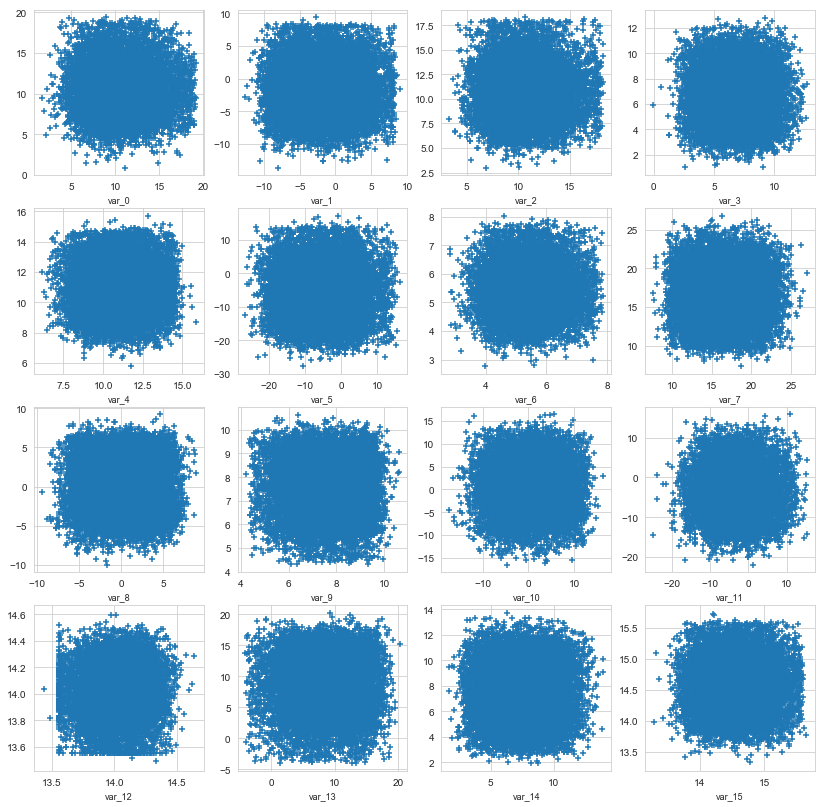

In [9]:
features = ['var_0', 'var_1','var_2','var_3', 'var_4', 'var_5', 'var_6', 'var_7', 
           'var_8', 'var_9', 'var_10','var_11','var_12', 'var_13', 'var_14', 'var_15', 
           ]
plot_feature_scatter(train_df[::20],test_df[::20], features)

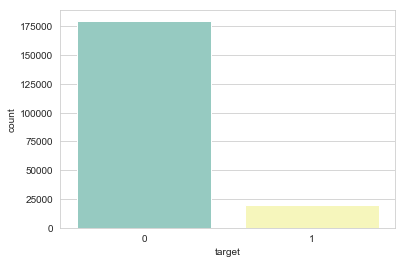

In [10]:
sns.countplot(train_df['target'], palette='Set3')

In [11]:
print("There are {}% target values with 1".format(100 * train_df["target"].value_counts()[1]/train_df.shape[0]))

There are 10.049% target values with 1


## Density plots of features

In [12]:
def plot_feature_distribution(df1, df2, label1, label2, features):
    i = 0
    sns.set_style('white')
#     sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(1, 2, figsize=(50, 25))
#     fig, ax = plt.subplots(10,10,figsize=(18,22))

    for feature in features:
        i += 1
        plt.subplot(1, 2, i)
#         plt.subplot(10,10,i)
        sns.distplot(df1[feature], kde_kws={"lw": 8}, hist=False, label=label1)
        sns.distplot(df2[feature], kde_kws={"lw": 8}, hist=False, label=label2)
        plt.xlabel(feature, fontsize=100)
#         plt.xlabel(feature, fontsize=9)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=80)
        plt.tick_params(axis='y', which='major', labelsize=80)
        plt.legend(loc = 0, prop = {'size':100})
#         plt.tick_params(axis='x', which='major', labelsize=6, pad=-6)
#         plt.tick_params(axis='y', which='major', labelsize=6)
    plt.show();

<Figure size 432x288 with 0 Axes>

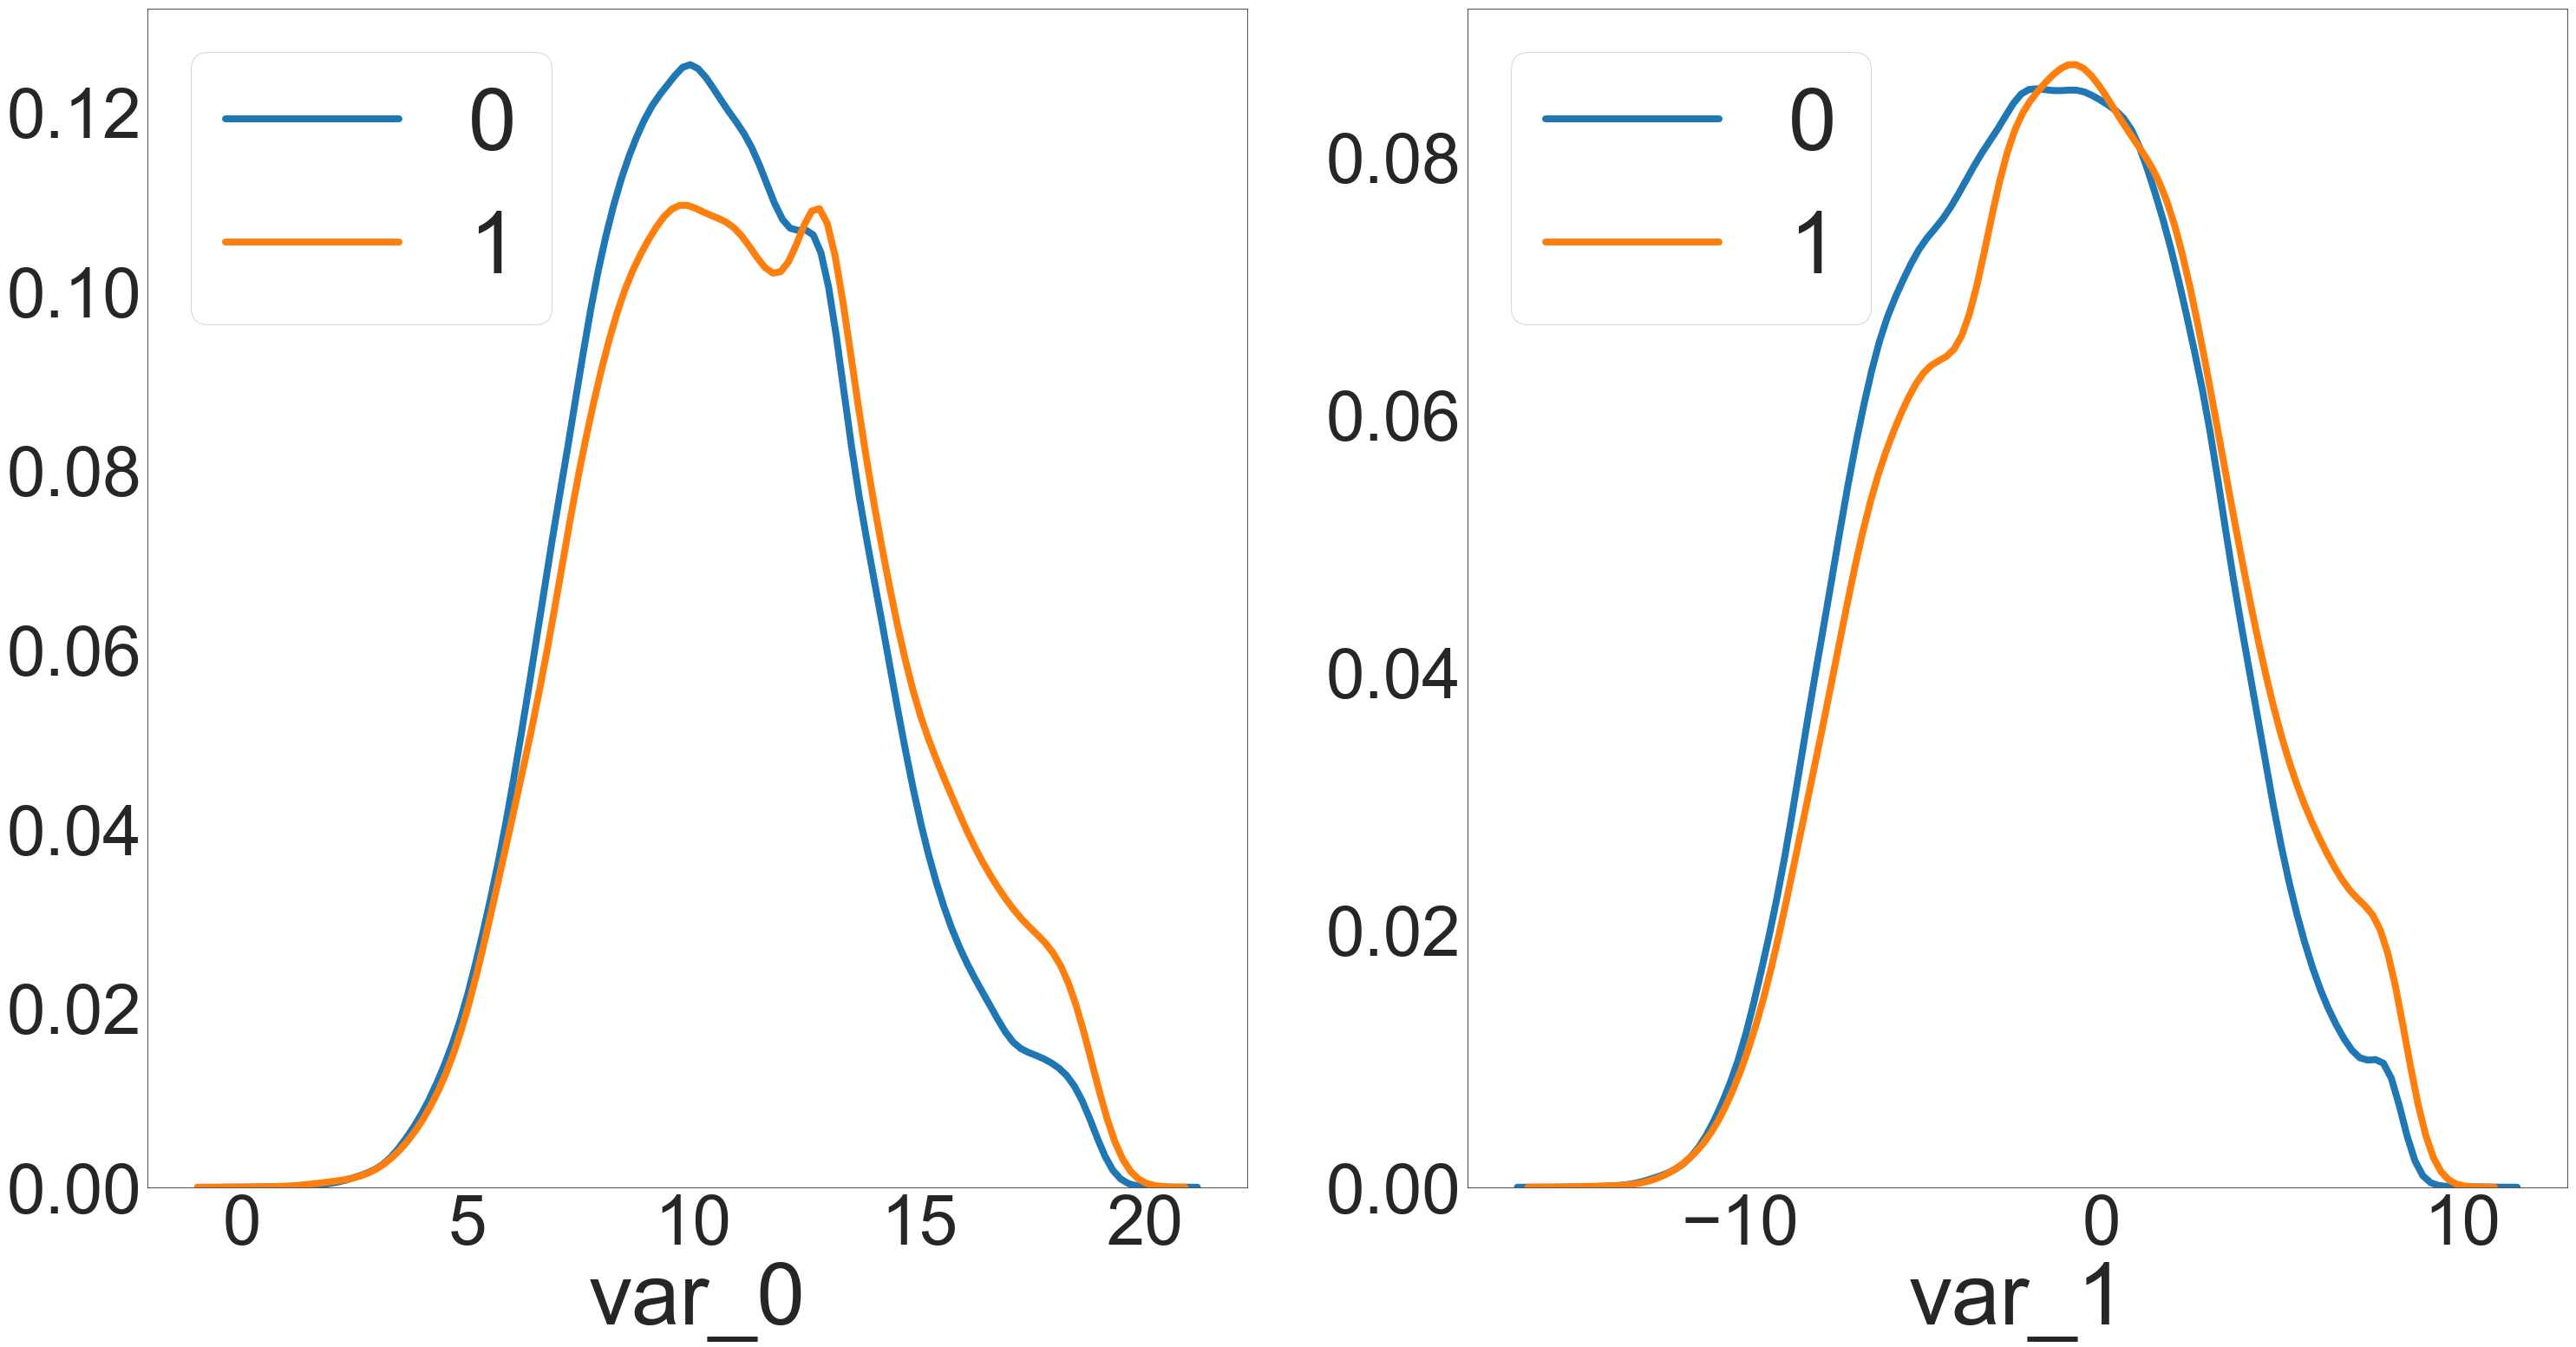

In [13]:
t0 = train_df.loc[train_df['target'] == 0]
t1 = train_df.loc[train_df['target'] == 1]
# features = train_df.columns.values[2:102]
features = train_df.columns.values[2:4]
plot_feature_distribution(t0, t1, '0', '1', features)

# features = train_df.columns.values[10:12]
# plot_feature_distribution(t0, t1, '0', '1', features)

# features = train_df.columns.values[102:202]
# plot_feature_distribution(t0, t1, '0', '1', features)

# -------------------------------------------------------------------------------

# features = train_df.columns.values[2:102]
# plot_feature_distribution(train_df, test_df, 'train', 'test', features)
# 
# features = train_df.columns.values[102:202]
# plot_feature_distribution(train_df, test_df, 'train', 'test', features)

<Figure size 432x288 with 0 Axes>

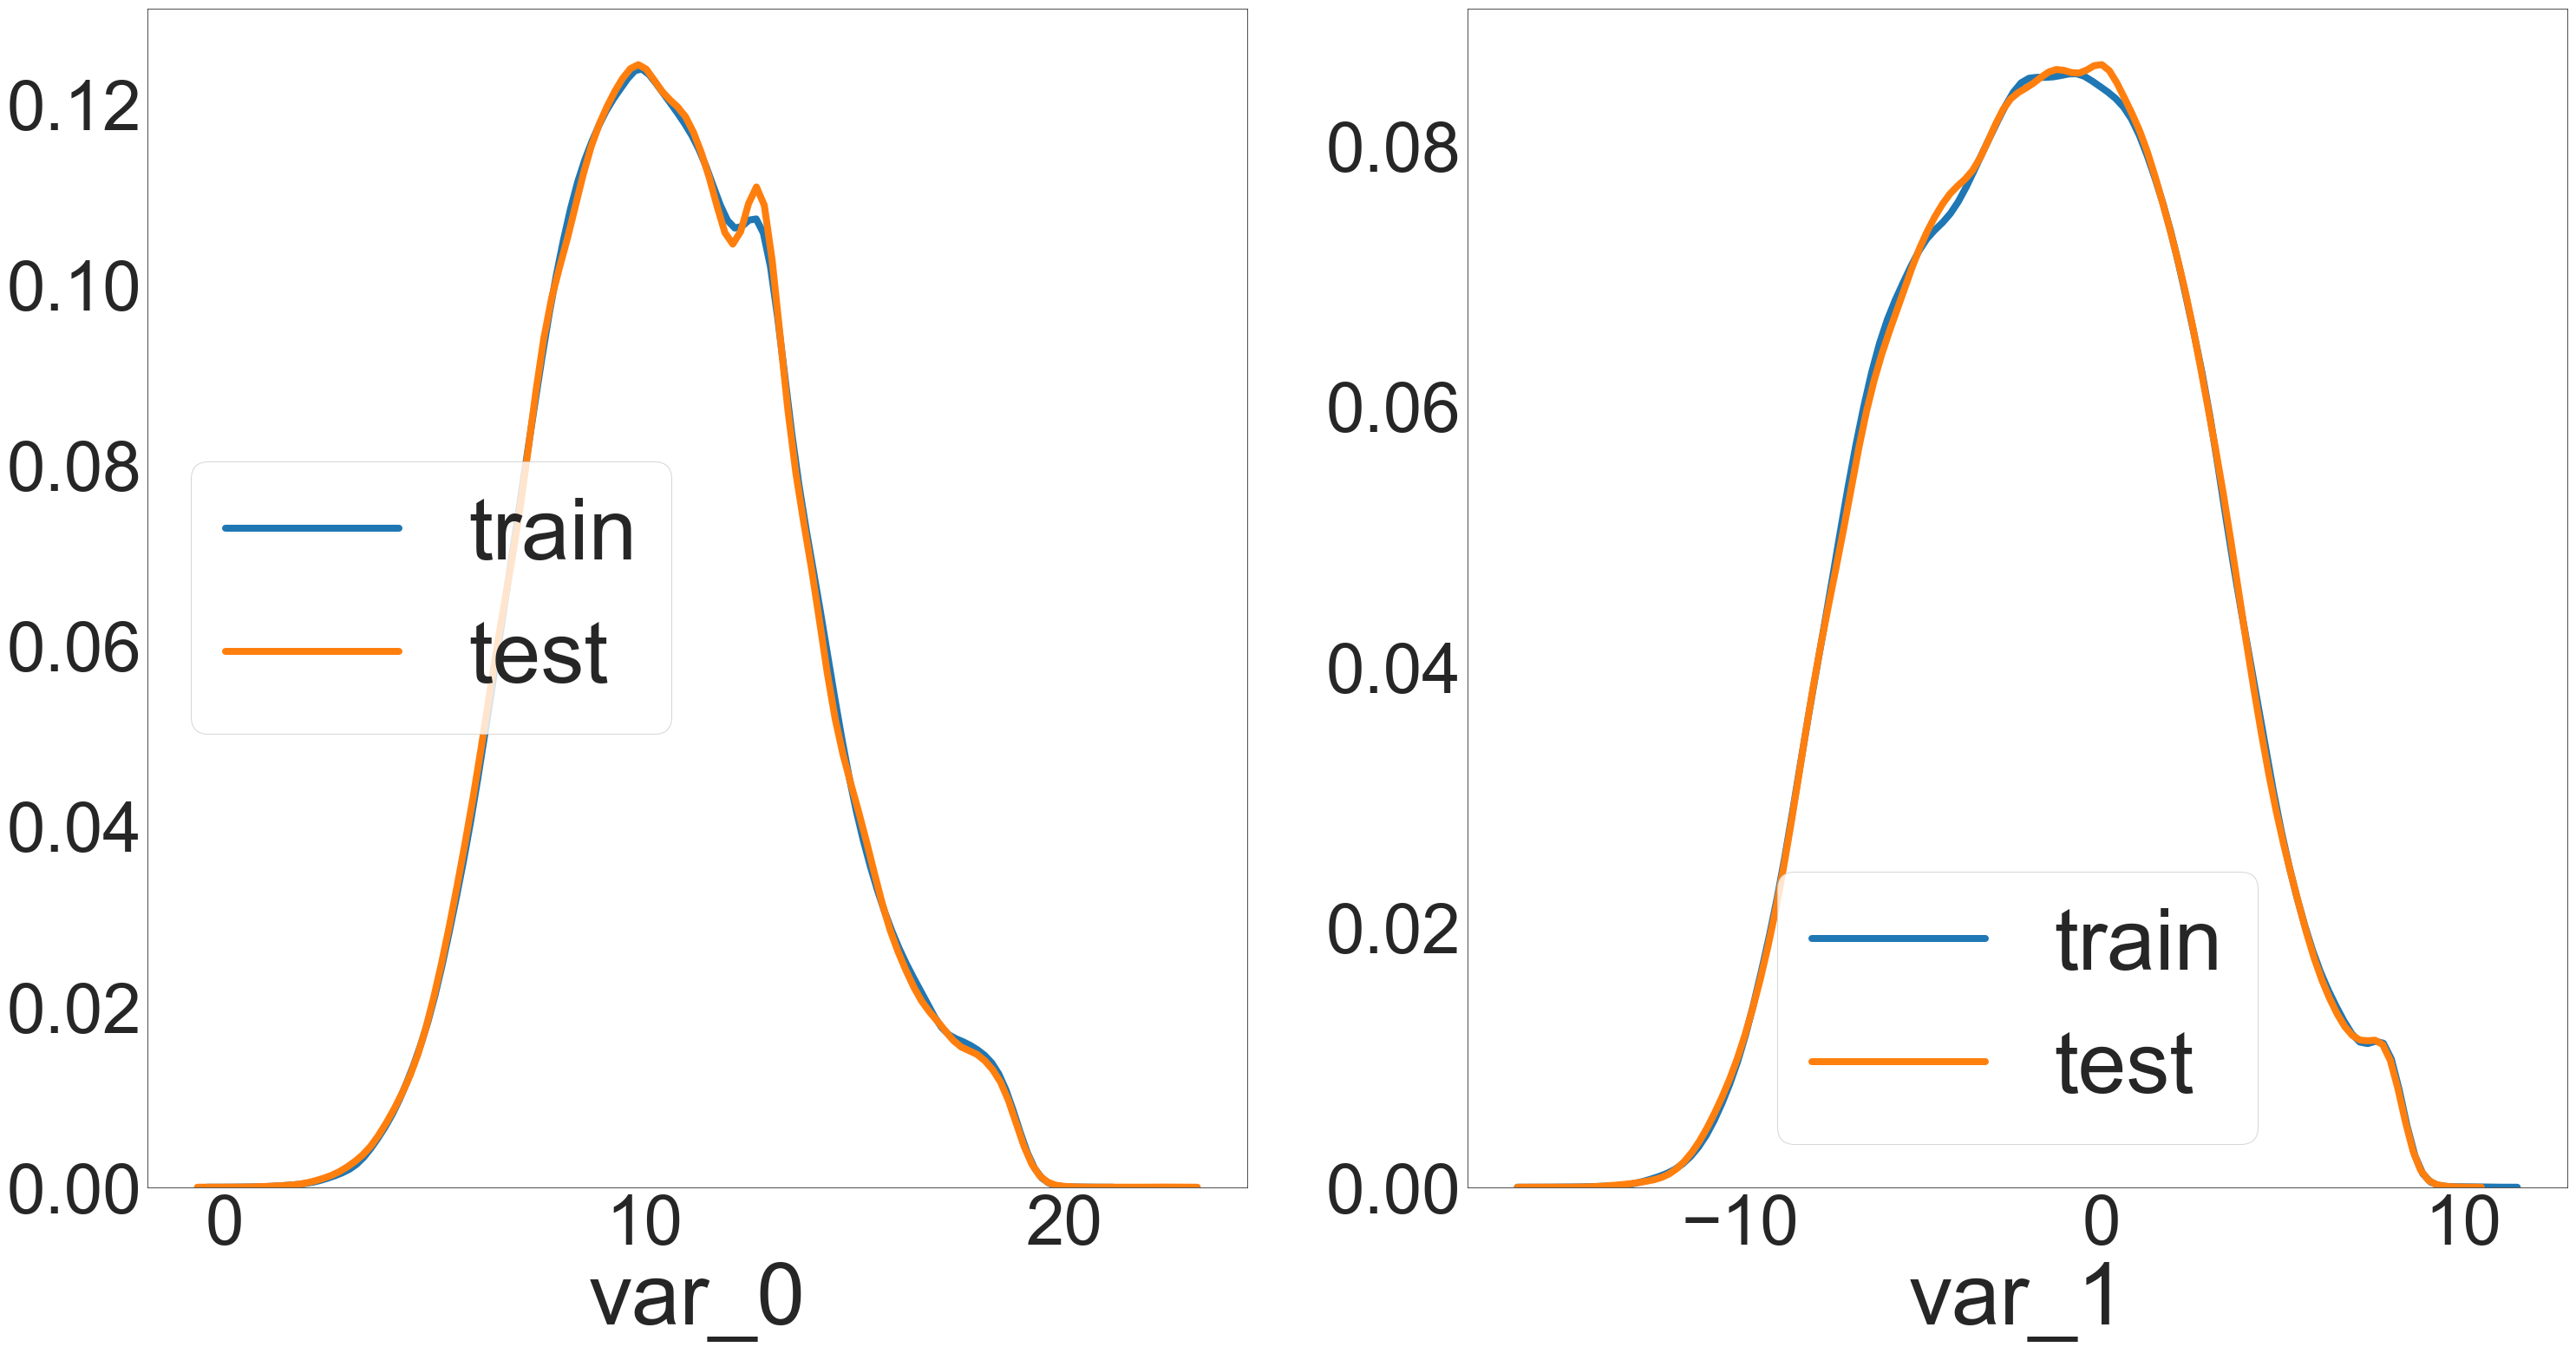

In [14]:
features = train_df.columns.values[2:4]
plot_feature_distribution(train_df, test_df, 'train', 'test', features)

In [15]:
idx = features = train_df.columns.values[2:202]
for df in [test_df, train_df]:
    df['sum'] = df[idx].sum(axis=1)  
    df['min'] = df[idx].min(axis=1)
    df['max'] = df[idx].max(axis=1)
    df['mean'] = df[idx].mean(axis=1)
    df['std'] = df[idx].std(axis=1)
    df['skew'] = df[idx].skew(axis=1)
    df['kurt'] = df[idx].kurtosis(axis=1)
    df['med'] = df[idx].median(axis=1)

In [16]:
train_df[train_df.columns[202:]].head()

,sum,min,max,mean,std,skew,kurt,med
0,1456.3182,-21.4494,43.1127,7.281591,9.331540,0.101580,1.331023,6.77040
1,1415.3636,-47.3797,40.5632,7.076818,10.336130,-0.351734,4.110215,7.22315
2,1240.8966,-22.4038,33.8820,6.204483,8.753387,-0.056957,0.546438,5.89940
3,1288.2319,-35.1659,38.1015,6.441160,9.594064,-0.480116,2.630499,6.70260
4,1354.2310,-65.4863,41.1037,6.771155,11.287122,-1.463426,9.787399,6.94735


In [17]:
test_df[test_df.columns[201:]].head()

,sum,min,max,mean,std,skew,kurt,med
0,1416.6404,-31.9891,42.0248,7.083202,9.910632,-0.088518,1.871262,7.31440
1,1249.6860,-41.1924,35.6020,6.248430,9.541267,-0.559785,3.391068,6.43960
2,1430.2599,-34.3488,39.3654,7.151300,9.967466,-0.135084,2.326901,7.26355
3,1411.4447,-21.4797,40.3383,7.057224,8.257204,-0.167741,2.253054,6.89675
4,1423.7364,-24.8254,45.5510,7.118682,10.043542,0.293484,2.044943,6.83375


In [18]:
def plot_new_feature_distribution(df1, df2, label1, label2, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(2,4,figsize=(18,10))

    for feature in features:
        i += 1
        plt.subplot(2,4,i)
        sns.kdeplot(df1[feature], bw=0.5,label=label1)
        sns.kdeplot(df2[feature], bw=0.5,label=label2)
        plt.xlabel(feature, fontsize=18)
        locs, labels = plt.xticks()
        plt.legend(loc = 0, prop = {'size':18})
        plt.tick_params(axis='x', which='major', labelsize=15)
        plt.tick_params(axis='y', which='major', labelsize=15)
    plt.show();

<Figure size 432x288 with 0 Axes>

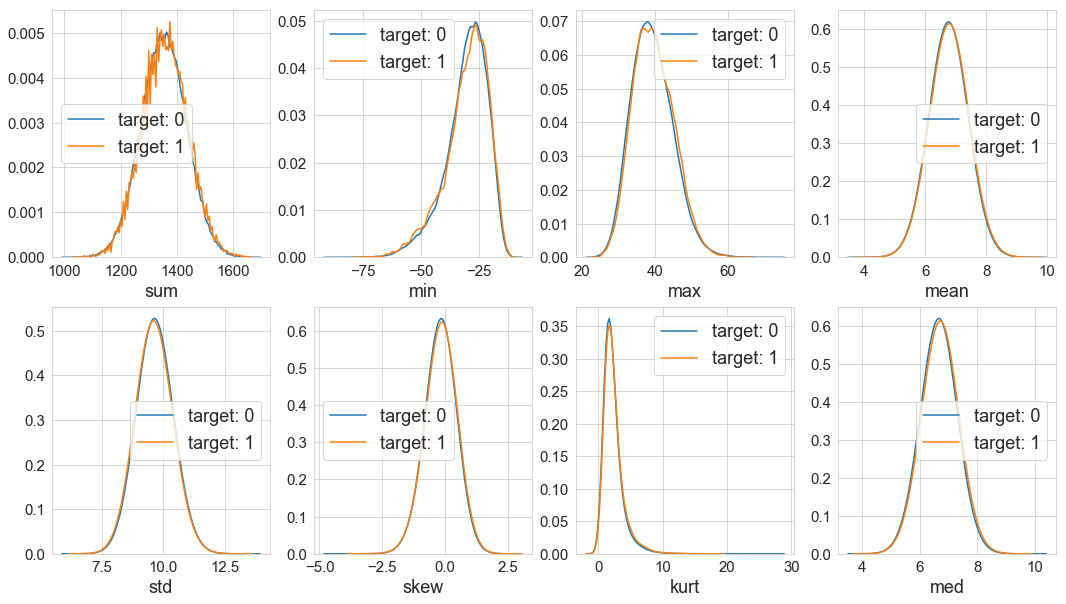

In [19]:
t0 = train_df.loc[train_df['target'] == 0]
t1 = train_df.loc[train_df['target'] == 1]
features = train_df.columns.values[202:]
plot_new_feature_distribution(t0, t1, 'target: 0', 'target: 1', features)

<Figure size 432x288 with 0 Axes>

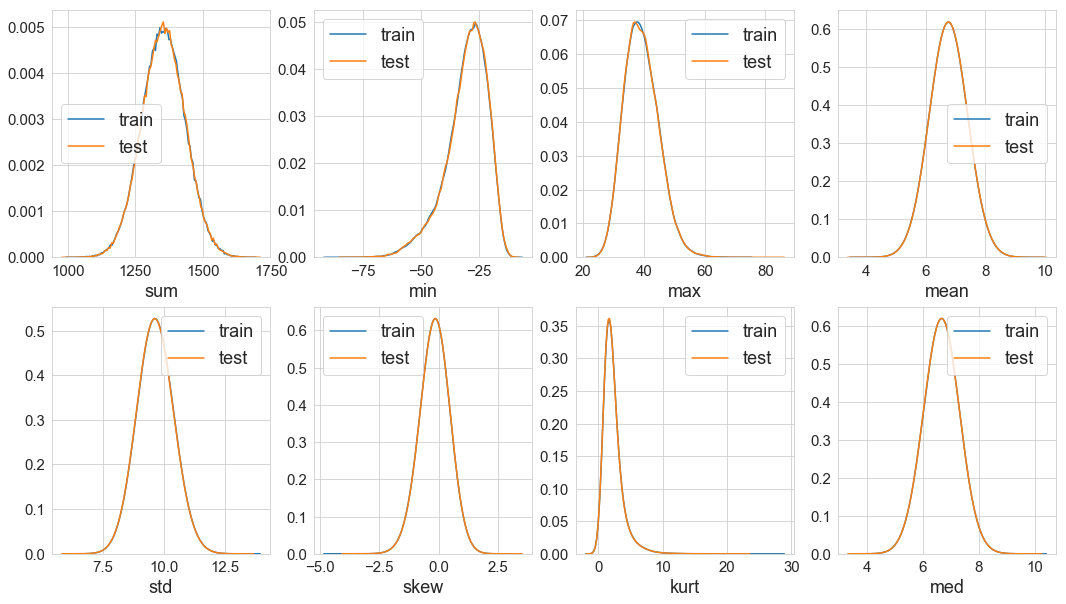

In [26]:
features = train_df.columns.values[202:]
plot_new_feature_distribution(train_df, test_df, 'train', 'test', features)

In [20]:
print('Train and test columns: {} {}'.format(len(train_df.columns), len(test_df.columns)))

Train and test columns: 210 209


## Model

In [21]:
features = [c for c in train_df.columns if c not in ['ID_code', 'target']]
target = train_df['target']

In [22]:
param = {
    'bagging_freq': 5,
    'bagging_fraction': 0.4,
    'boost_from_average':'false',
    'boost': 'gbdt',
    'feature_fraction': 0.05,
    'learning_rate': 0.01,
    'max_depth': -1,  
    'metric':'auc',
    'min_data_in_leaf': 80,
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves': 13,
    'num_threads': 8,
    'tree_learner': 'serial',
    'objective': 'binary', 
    'verbosity': 1
}

In [23]:
folds = StratifiedKFold(n_splits=10, shuffle=False, random_state=44000)
oof = np.zeros(len(train_df))
predictions = np.zeros(len(test_df))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_df.values, target.values)):
    print("Fold {}".format(fold_))
    trn_data = lgb.Dataset(train_df.iloc[trn_idx][features], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(train_df.iloc[val_idx][features], label=target.iloc[val_idx])

    num_round = 1000000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 3000)
    oof[val_idx] = clf.predict(train_df.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test_df[features], num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(roc_auc_score(target, oof)))

Fold 0
Training until validation scores don't improve for 3000 rounds.
[1000]	training's auc: 0.900229	valid_1's auc: 0.881617
[2000]	training's auc: 0.91128	valid_1's auc: 0.889429
[3000]	training's auc: 0.918765	valid_1's auc: 0.893439
[4000]	training's auc: 0.924616	valid_1's auc: 0.895931
[5000]	training's auc: 0.929592	valid_1's auc: 0.897636
[6000]	training's auc: 0.933838	valid_1's auc: 0.898786
[7000]	training's auc: 0.937858	valid_1's auc: 0.899318
[8000]	training's auc: 0.941557	valid_1's auc: 0.899733
[9000]	training's auc: 0.94517	valid_1's auc: 0.899901
[10000]	training's auc: 0.948529	valid_1's auc: 0.900143
[11000]	training's auc: 0.951807	valid_1's auc: 0.900281
[12000]	training's auc: 0.954903	valid_1's auc: 0.900269
[13000]	training's auc: 0.957815	valid_1's auc: 0.900107
[14000]	training's auc: 0.960655	valid_1's auc: 0.89994
Early stopping, best iteration is:
[11603]	training's auc: 0.953681	valid_1's auc: 0.900347
Fold 1
Training until validation scores don't impro

[7000]	training's auc: 0.937896	valid_1's auc: 0.900785
[8000]	training's auc: 0.941574	valid_1's auc: 0.900916
[9000]	training's auc: 0.945132	valid_1's auc: 0.901081
[10000]	training's auc: 0.948568	valid_1's auc: 0.901075
[11000]	training's auc: 0.951714	valid_1's auc: 0.901069
[12000]	training's auc: 0.954815	valid_1's auc: 0.901025
[13000]	training's auc: 0.957792	valid_1's auc: 0.901129
Early stopping, best iteration is:
[10567]	training's auc: 0.950365	valid_1's auc: 0.901193
CV score: 0.90025 


In [27]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:150].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

In [43]:
bfea = best_features.sort_values(by="importance",ascending=False)
bfea.shape

(1500, 3)

In [30]:
bfea.head()

,Feature,importance,fold
108,var_108,979,2
108,var_108,971,1
13,var_13,953,1
154,var_154,947,1
80,var_80,934,1


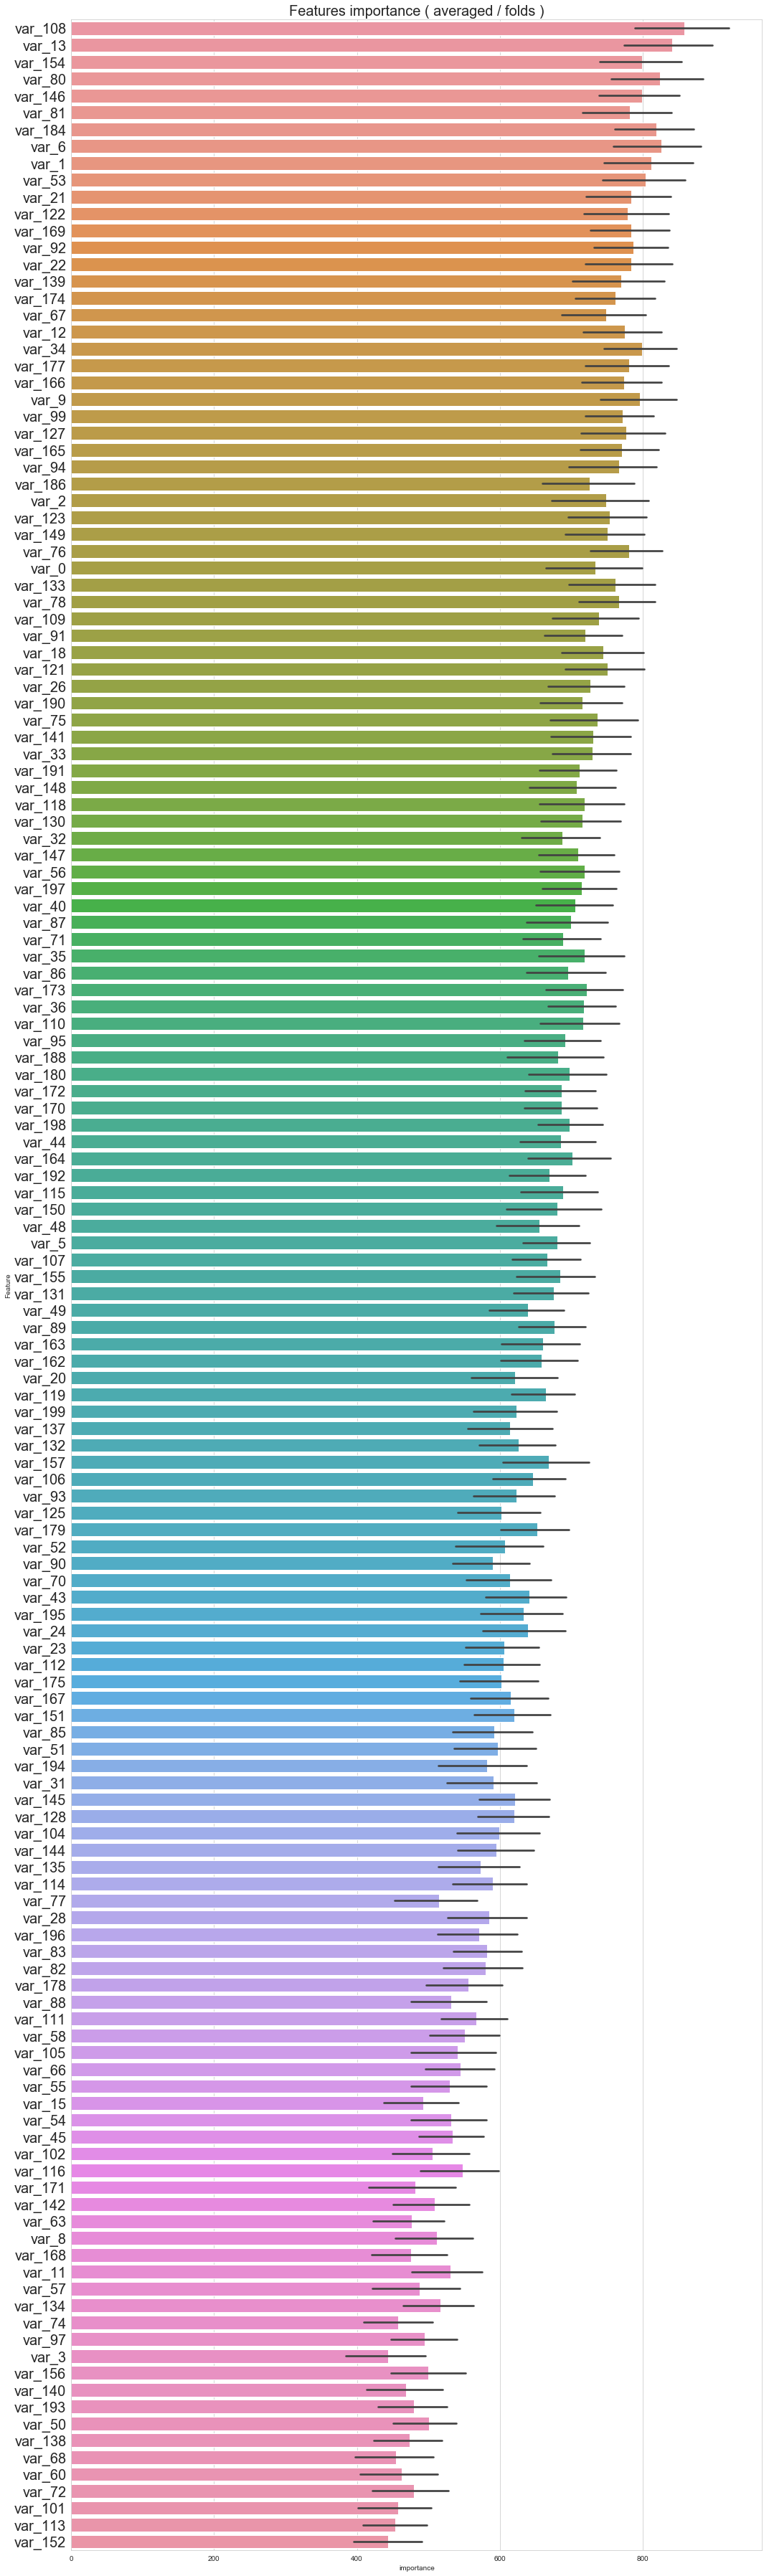

In [42]:
plt.figure(figsize=(15,50))
sns.barplot(x="importance", y="Feature", data=bfea)
plt.title('Features importance ( averaged / folds )', fontsize=20)
plt.tick_params(axis='y', labelsize=20)
plt.tight_layout()
plt.savefig('FI.png')

In [25]:
sub_df = pd.DataFrame({"ID_code":test_df["ID_code"].values})
sub_df["target"] = predictions
sub_df.to_csv("LGBM_submission.csv", index=False)

## LDA

In [76]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis(n_components=2)
lda.fit(train_df.drop(['target', 'ID_code'], axis=1), train_df['target'])
# X_new = lda.transform(X)
# plt.scatter(X_new[:, 0], X_new[:, 1],marker='o',c=y)
# plt.show()

LinearDiscriminantAnalysis(n_components=2, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

In [77]:
ldapre = lda.predict_proba(test_df.drop(['ID_code'], axis=1))

In [78]:
sub = pd.read_csv('./input/sample_submission.csv')
sub['target'] = ldapre
sub.to_csv('LDA_submission.csv',index=False)

## ------------------

In [84]:
train_df.shape

(200000, 202)

In [99]:
features = train_df.columns.values[2:202]
print(features.shape)
print(features)

(200,)
['var_0' 'var_1' 'var_2' 'var_3' 'var_4' 'var_5' 'var_6' 'var_7' 'var_8'
 'var_9' 'var_10' 'var_11' 'var_12' 'var_13' 'var_14' 'var_15' 'var_16'
 'var_17' 'var_18' 'var_19' 'var_20' 'var_21' 'var_22' 'var_23' 'var_24'
 'var_25' 'var_26' 'var_27' 'var_28' 'var_29' 'var_30' 'var_31' 'var_32'
 'var_33' 'var_34' 'var_35' 'var_36' 'var_37' 'var_38' 'var_39' 'var_40'
 'var_41' 'var_42' 'var_43' 'var_44' 'var_45' 'var_46' 'var_47' 'var_48'
 'var_49' 'var_50' 'var_51' 'var_52' 'var_53' 'var_54' 'var_55' 'var_56'
 'var_57' 'var_58' 'var_59' 'var_60' 'var_61' 'var_62' 'var_63' 'var_64'
 'var_65' 'var_66' 'var_67' 'var_68' 'var_69' 'var_70' 'var_71' 'var_72'
 'var_73' 'var_74' 'var_75' 'var_76' 'var_77' 'var_78' 'var_79' 'var_80'
 'var_81' 'var_82' 'var_83' 'var_84' 'var_85' 'var_86' 'var_87' 'var_88'
 'var_89' 'var_90' 'var_91' 'var_92' 'var_93' 'var_94' 'var_95' 'var_96'
 'var_97' 'var_98' 'var_99' 'var_100' 'var_101' 'var_102' 'var_103'
 'var_104' 'var_105' 'var_106' 'var_107' 'var_108'

In [100]:
correlations = train_df[features].corr().abs().unstack().sort_values(kind="quicksort").reset_index()
correlations = correlations[correlations['level_0'] != correlations['level_1']]

In [101]:
correlations.head(10)
# correlations.tail(10)

,level_0,level_1,0
0,var_75,var_191,2.703975e-08
1,var_191,var_75,2.703975e-08
2,var_173,var_6,5.942735e-08
3,var_6,var_173,5.942735e-08
4,var_126,var_109,1.313947e-07
5,var_109,var_126,1.313947e-07
6,var_144,var_27,1.772502e-07
7,var_27,var_144,1.772502e-07
8,var_177,var_100,3.116544e-07
9,var_100,var_177,3.116544e-07


In [104]:
correlations.loc[(correlations['level_0']=='var_75') & ('var_191'== correlations['level_1'])]

,level_0,level_1,0
0,var_75,var_191,2.703975e-08


In [105]:
correlations.loc[(correlations['level_0']=='var_183') & ('var_189'== correlations['level_1'])]

,level_0,level_1,0
39790,var_183,var_189,0.009359
